# LinkedIn Data Analysis Notebook

## Objectives:

- Find the degree of each student
- Given any pair of students, find a random walk connecting them.

    - Prune this random walk to find a path connecting the given pair or
      students.

    - Compute some statistical estimates of the length of these random
      walks and the pruned paths.

### Note on G vs G_su:

- `G`: Full LinkedIn graph from JSON (all nodes, even partial ones).
- `G_su`: Clean subgraph with only SU students (from AllSU.csv).

**Why this is needed:**
1. Many non-SU nodes have incomplete data (no CSV submitted).
2. Including them can distort metrics like degree, centrality, etc.
3. `G_su` ensures fair, complete, and focused analysis.

In [7]:
# Imports
import json
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import mean
import statistics

`G`: Full LinkedIn graph from JSON (all nodes, even partial ones).

In [8]:
# Load Cleaned Graph
with open("cleaned_adjacency_list.json", "r", encoding="utf-8") as f:
    adjacency_list = json.load(f)

# Convert Adjacency List to NetworkX Graph
G = nx.Graph()
for student, connections in adjacency_list.items():
    for conn in connections:
        G.add_edge(student, conn)

print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph loaded with 28555 nodes and 100693 edges


In [9]:
def normalize_name(name):
    return name.strip().lower()


`G_su`: Clean subgraph with only SU students (from AllSU.csv).

In [10]:

# Load cleaned adjacency list (full graph)
with open("cleaned_adjacency_list.json") as f:
    full_adj = json.load(f)

# Load SU list with possible duplicates
df_su = pd.read_csv("AllSU.csv")
df_su['Full Name'] = df_su['Full Name'].apply(normalize_name)

# Keep the order and duplicates from CSV
su_name_list = df_su['Full Name'].tolist()

# Track edges and missing students
su_edges = []
missing_students = []

for name in su_name_list:
    if name in full_adj:
        # Connect only to other SU students
        connections = [conn for conn in full_adj[name] if conn in su_name_list]
        for conn in connections:
            su_edges.append((name, conn))
    else:
        missing_students.append(name)

# Create the subgraph
G_su = nx.Graph()
G_su.add_edges_from(su_edges)
print(f"Graph loaded with {G_su.number_of_nodes()} nodes and {G_su.number_of_edges()} edges")


Graph loaded with 154 nodes and 9109 edges


Degree of Each Student



In [11]:
def compute_and_save_degrees(G, output_file):
    """
    Computes the degree of each node in the graph G,
    saves it as a sorted JSON file, and prints the top 10 nodes.

    Parameters:
        G (networkx.Graph): The graph to analyze.
        output_file (str): Filename to save the degree JSON.

    Returns:
        list[dict]: Sorted list of student-degree dicts.
    """
    # Degree of each student
    degree_dict = dict(G.degree())
    degree_df = pd.DataFrame(degree_dict.items(), columns=["Student", "Degree"])

    # Sort in descending order
    degree_df_sorted = degree_df.sort_values(by="Degree", ascending=False)

    # Save to JSON (as list of dicts for readability)
    degree_json = degree_df_sorted.to_dict(orient="records")
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(degree_json, f, indent=4)

    # Display top 10
    print(degree_df_sorted.head(10))


In [12]:
compute_and_save_degrees(G,"all_degree_sorted.json")

                  Student  Degree
314         rohit malviya    4258
303           ravi rajput    4068
197           manoj dewda    3967
297          ramraj nagar    3711
238         nirmal mewada    3523
264         pranjal dubey    3342
101  challa trivedh kumar    2913
226         neeraj parmar    2682
153        himanshu kumar    2667
425            aman singh    2653


In [13]:
compute_and_save_degrees(G_su,"su_degree_sorted.json")

            Student  Degree
10   anamika kumari     153
56      manoj dewda     151
105   shivang dubey     151
104   shivam shukla     151
117     vinay kumar     151
113    suyash yadav     151
42   himanshu kumar     151
59       mayank raj     151
36   gaurav rathore     150
2        ajay jatav     150


Random Walk Between Students

In [14]:
def random_walk_graph(G, start, end, min_steps=5, max_steps=200, max_attempts=10):
    """Random walk on a NetworkX graph with name normalization."""
    start, end = normalize_name(start), normalize_name(end)
    
    if start not in G or end not in G:
        return None

    for _ in range(max_attempts):
        path = [start]
        visited = set([start])
        current = start

        for _ in range(max_steps):
            neighbors = list(G.neighbors(current))
            if not neighbors:
                break

            unvisited = [n for n in neighbors if n not in visited]
            next_node = random.choice(neighbors)


            path.append(next_node)
            visited.add(next_node)
            current = next_node

            if current == end and len(path) >= min_steps:
                return path

    return None


In [15]:
path=random_walk_graph(G_su,"disha sahu","hiranya patil")

In [16]:
print(path)

['disha sahu', 'deepak mandal', 'arun singh', 'rohit kahar', 'lakhan rathore', 'anushri mishra', 'guman singh', 'ranjeet yadav', 'naman damami', 'n. arun kumar', 'pooran singh', 'neeraj parmar', 'priya saini', 'shubham kumar', 'prachi dhakad', 'gaurav tiwari', 'vinay kumar', 'hiranya patil']


 Prune to Valid Path (Remove Loops)

In [17]:
def prune_path(walk):
    start = walk[0]
    end = walk[-1]
    pruned = []
    seen = set()
    
    for node in walk:
        if node in seen:
            continue  # skip repeated nodes
        pruned.append(node)
        seen.add(node)
        if node == end:
            break  # stop when we reach the first appearance of the end node
    
    return pruned if pruned[-1] == end else []


In [18]:
prune_path(path)

['disha sahu',
 'deepak mandal',
 'arun singh',
 'rohit kahar',
 'lakhan rathore',
 'anushri mishra',
 'guman singh',
 'ranjeet yadav',
 'naman damami',
 'n. arun kumar',
 'pooran singh',
 'neeraj parmar',
 'priya saini',
 'shubham kumar',
 'prachi dhakad',
 'gaurav tiwari',
 'vinay kumar',
 'hiranya patil']

In [19]:
def get_degree_rank(student_name, degree_json_path="all_degree_sorted.json"):
    student_name = student_name.strip().lower()

    with open(degree_json_path, "r", encoding="utf-8") as f:
        degree_data = json.load(f)

    # Go through sorted list and find the rank
    for rank, entry in enumerate(degree_data, start=1):
        if entry["Student"] == student_name:
            return {
                "Student": entry["Student"],
                "Degree": entry["Degree"],
                "Rank": rank
            }

    return {"Error": f"'{student_name}' not found in the degree list."}

In [20]:
Sitare_Members=["Shilpa Singhal","Amit Singhal",'Kushal Shah',"Anuja Agarwal","Vishal Yadav","Preeti Shukla","Saurabh Pandey","Pintu Lohar,phd","Achal Agarwal,phd","Siddhant Gupta","Abhinav Mishra","Ashwini Singh","Saurabh Kumar","Riya Vithal Bangera","Dheerendra Mishra","Rajat Singh"]

In [21]:
# Collect insights
results = [get_degree_rank(name) for name in Sitare_Members]

# Filter out errors
valid_results = [res for res in results if "Error" not in res]

# Sort by Rank (ascending)
sorted_results = sorted(valid_results, key=lambda x: x["Rank"])

# Print sorted insights
for res in sorted_results:
    print(f"{res['Student']} — Degree: {res['Degree']}, Rank: {res['Rank']}")


amit singhal — Degree: 122, Rank: 132
preeti shukla — Degree: 118, Rank: 139
siddhant gupta — Degree: 98, Rank: 183
kushal shah — Degree: 88, Rank: 204
saurabh kumar — Degree: 84, Rank: 220
vishal yadav — Degree: 83, Rank: 226
dheerendra mishra — Degree: 80, Rank: 233
shilpa singhal — Degree: 52, Rank: 292
saurabh pandey — Degree: 23, Rank: 697
abhinav mishra — Degree: 22, Rank: 745
rajat singh — Degree: 8, Rank: 2456
anuja agarwal — Degree: 2, Rank: 10498


In [22]:
get_degree_rank("Disha Sahu")

{'Student': 'disha sahu', 'Degree': 405, 'Rank': 72}

In [23]:

def load_and_preprocess_degree_data(all_degree_file, su_degree_file):
    # Load the degree data from JSON files
    with open(all_degree_file, 'r') as file:
        all_degree_data = json.load(file)

    with open(su_degree_file, 'r') as file:
        su_degree_data = json.load(file)

    # Convert data into pandas DataFrames
    df_all = pd.DataFrame(all_degree_data)
    df_su = pd.DataFrame(su_degree_data)

    # Normalize the 'Student' column to ensure they match
    df_all['Student'] = df_all['Student'].apply(normalize_name)
    df_su['Student'] = df_su['Student'].apply(normalize_name)

    # Merge dataframes on 'Student' column
    combined = pd.merge(df_all, df_su, on='Student', how='outer', suffixes=('_G', '_G_su'))

    # Handle missing data by filling NaNs with 0
    combined.fillna(0, inplace=True)

    # Calculate outsider degree (Difference between full graph and university subgraph degrees)
    combined['Outsider_Degree'] = combined['Degree_G'] - combined['Degree_G_su']
    
    # Sort by Outsider Degree to highlight those with more outside connections
    combined_sorted = combined.sort_values(by='Outsider_Degree', ascending=False)

    return combined_sorted

def normalize_name(name):
    # Normalize names (strip, lower, etc.)
    return name.strip().lower()

combined_data = load_and_preprocess_degree_data('all_degree_sorted.json', 'su_degree_sorted.json')
print(combined_data.head())


             Student  Degree_G  Degree_G_su  Outsider_Degree
19832  rohit malviya      4258        147.0           4111.0
19071    ravi rajput      4068        150.0           3918.0
13225    manoj dewda      3967        151.0           3816.0
18843   ramraj nagar      3711        145.0           3566.0
15473  nirmal mewada      3523        150.0           3373.0


In [24]:

def plot_top_outsider_connections(combined_df, top_n=20):
    # Take top N students by outsider degree
    top_df = combined_df.sort_values(by='Outsider_Degree', ascending=False).head(top_n)
    
    students = top_df['Student'].str.title()
    degree_g = top_df['Degree_G']
    degree_su = top_df['Degree_G_su']

    x = np.arange(len(students))
    width = 0.35

    plt.figure(figsize=(14, 7))
    plt.bar(x - width/2, degree_g, width, label='Total Connections (G)', color='skyblue')
    plt.bar(x + width/2, degree_su, width, label='University Connections (G_su)', color='darkblue')

    plt.xticks(x, students, rotation=45, ha='right')
    plt.xlabel('Student')
    plt.ylabel('Degree')
    plt.title(f'Top {top_n} Students by Outsider Connections')
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


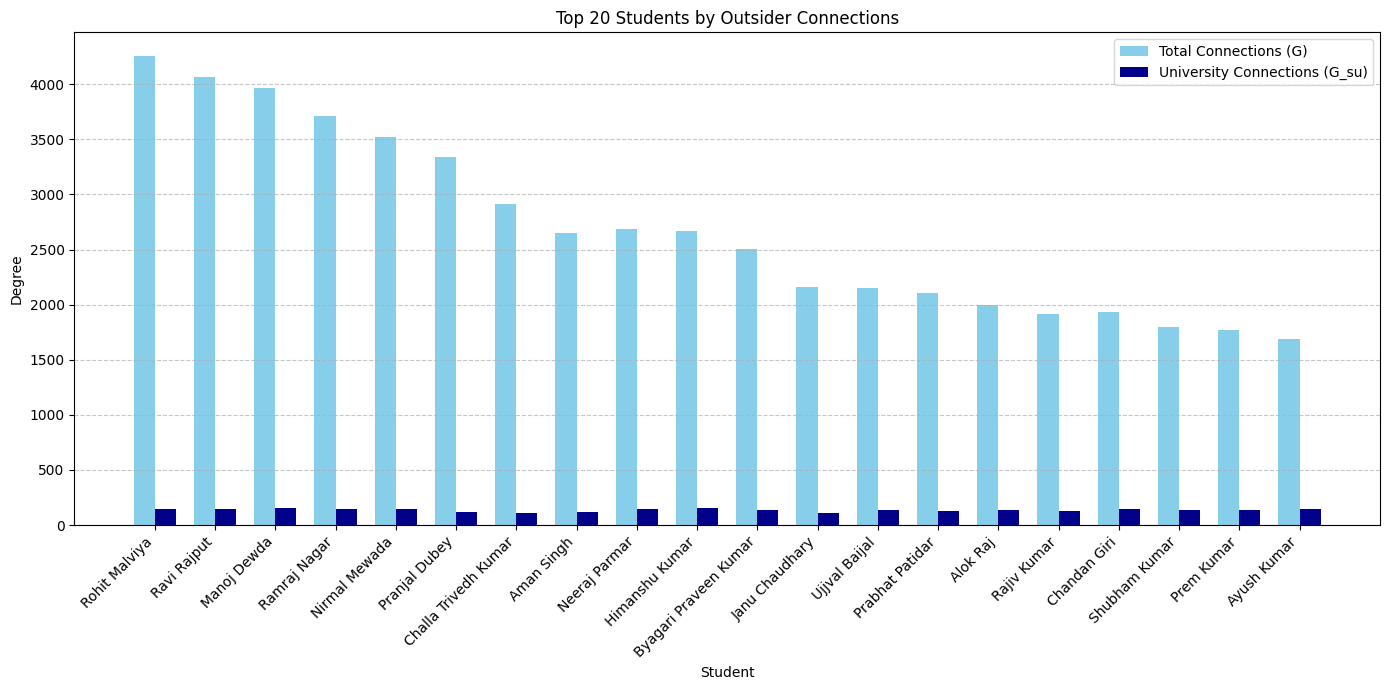

In [25]:
plot_top_outsider_connections(combined_data)

In [26]:
def summarize_outsider_connectors(df, top_n=10):
    top = df.sort_values(by='Outsider_Degree', ascending=False).head(top_n)

    print("\n=== Outsider Connector Report ===")
    print(f"Top {top_n} Students by External (Outsider) Connections:\n")

    print(f"{'Student':<25}{'Total (G)':<12}{'Internal (G_su)':<18}{'External (Outsiders)':<20}")
    print("-" * 75)

    for _, row in top.iterrows():
        name = row['Student'].title()
        total = int(row['Degree_G'])
        uni = int(row['Degree_G_su'])
        outside = int(row['Outsider_Degree'])
        print(f"{name:<25}{total:<12}{uni:<18}{outside:<20}")

    print("\nSummary Insights:")
    lead = top.iloc[0]
    print(f"• Highest external reach: {lead['Student'].title()} with {int(lead['Outsider_Degree'])} outsider connections.")

    avg_out = df['Outsider_Degree'].mean()
    print(f"• Average outsider connections per student: {avg_out:.2f}")

    max_ratio = top.apply(lambda row: row['Outsider_Degree'] / (row['Degree_G_su'] + 1e-5), axis=1).max()
    print(f"• Max External/Internal Ratio: {max_ratio:.2f} — indicating strong external outreach.\n")
    


In [27]:
summarize_outsider_connectors(combined_data, top_n=15)



=== Outsider Connector Report ===
Top 15 Students by External (Outsider) Connections:

Student                  Total (G)   Internal (G_su)   External (Outsiders)
---------------------------------------------------------------------------
Rohit Malviya            4258        147               4111                
Ravi Rajput              4068        150               3918                
Manoj Dewda              3967        151               3816                
Ramraj Nagar             3711        145               3566                
Nirmal Mewada            3523        150               3373                
Pranjal Dubey            3342        114               3228                
Challa Trivedh Kumar     2913        108               2805                
Aman Singh               2653        117               2536                
Neeraj Parmar            2682        148               2534                
Himanshu Kumar           2667        151               2516                


In [28]:
def load_graph_and_students():
    return G, G_su, list(G_su.nodes()) 

In [29]:
def analyze_graph(G, label, students, n_trials=100):
    print(f"\nAnalyzing {label}...\n")

    walk_lengths, path_lengths, middle_nodes = [], [], []
    longest_path = []

    for _ in range(n_trials):
        u, v = random.sample(students, 2)
        walk = random_walk_graph(G, u, v)
        if walk:
            pruned = prune_path(walk)
            walk_lengths.append(len(walk))
            path_lengths.append(len(pruned))
            middle_nodes += pruned[1:-1]
            if len(pruned) > len(longest_path):
                longest_path = pruned

    # Stats
    avg_walk = statistics.mean(walk_lengths) if walk_lengths else 0
    med_walk = statistics.median(walk_lengths) if walk_lengths else 0
    std_walk = statistics.stdev(walk_lengths) if len(walk_lengths) > 1 else 0

    avg_path = statistics.mean(path_lengths) if path_lengths else 0
    med_path = statistics.median(path_lengths) if path_lengths else 0
    std_path = statistics.stdev(path_lengths) if len(path_lengths) > 1 else 0

    max_path = len(longest_path)
    mid_counts = Counter(middle_nodes).most_common(10)

    # Display Summary
    print(f"• Avg Walk Length: {avg_walk:.2f} | Median: {med_walk} | Std Dev: {std_walk:.2f}")
    print(f"• Avg Pruned Path: {avg_path:.2f} | Median: {med_path} | Std Dev: {std_path:.2f}")
    print(f"• Longest Path Found: {max_path}")
    
    print(f"\nTop Mid-Path Students in {label}:")
    for name, count in mid_counts:
        print(f"  - {name}: {count} times")

    # Smart Insights
    print("\n Insights:")
    if avg_path > 8:
        print("• Deep connections — long and meaningful paths.")
    elif avg_path > 4:
        print("• Moderate interconnection among nodes.")
    else:
        print("• Shallow or shortcut-dominated paths.")
    
    if mid_counts:
        print(f"• '{mid_counts[0][0]}' appears as a strong connector in {label}.")
    if max_path > 15:
        print("• Longest paths hint at isolated or loosely connected groups.")
    if len(G) > 200 and len(G.edges) < 2 * len(G):
        print("• Sparse network — consider boosting intra-class engagement.")

    return pd.DataFrame({
        "Walk Length": walk_lengths,
        "Pruned Path Length": path_lengths
    }), mid_counts


In [30]:
def unified_graph_analysis_pipeline():
    G, G_su, students = load_graph_and_students()

    # Analyze Full Graph (G)
    df_G, mids_G = analyze_graph(G, "G (Full Graph)", students)

    # Analyze University Graph (G_su)
    df_Gsu, mids_Gsu = analyze_graph(G_su, "G_su (University)", students)

    # Plot Distribution Once
    plot_path_distributions(df_G, df_Gsu)

    # Print Top Mid-path Students (if needed for clarity)
    print("\n Top Mid-Path Students in G:")
    for name, count in mids_G:
        print(f"  {name} — {count} times")

    print("\n Top Mid-Path Students in G_su:")
    for name, count in mids_Gsu:
        print(f"  {name} — {count} times")

def plot_path_distributions(df_G, df_Gsu):
    plt.figure(figsize=(12, 6))
    sns.histplot(df_G['Pruned Path Length'], bins=20, kde=True, color='skyblue', label='G (All)')
    sns.histplot(df_Gsu['Pruned Path Length'], bins=20, kde=True, color='darkblue', label='G_su (University)')
    plt.legend()
    plt.title("Path Length Distribution: G vs G_su")
    plt.xlabel("Pruned Path Length")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



Analyzing G (Full Graph)...

• Avg Walk Length: 93.15 | Median: 86.0 | Std Dev: 55.17
• Avg Pruned Path: 70.94 | Median: 68.0 | Std Dev: 38.87
• Longest Path Found: 147

Top Mid-Path Students in G (Full Graph):
  - rohit malviya: 57 times
  - nirmal mewada: 53 times
  - ravi rajput: 51 times
  - neeraj parmar: 50 times
  - manoj dewda: 50 times
  - byagari praveen kumar: 47 times
  - challa trivedh kumar: 46 times
  - aman singh: 45 times
  - himanshu kumar: 42 times
  - janu chaudhary: 40 times

 Insights:
• Deep connections — long and meaningful paths.
• 'rohit malviya' appears as a strong connector in G (Full Graph).
• Longest paths hint at isolated or loosely connected groups.

Analyzing G_su (University)...

• Avg Walk Length: 78.28 | Median: 60 | Std Dev: 59.97
• Avg Pruned Path: 53.35 | Median: 46 | Std Dev: 34.11
• Longest Path Found: 112

Top Mid-Path Students in G_su (University):
  - anamika kumari: 51 times
  - anoop kumar: 50 times
  - mohit sharma: 48 times
  - dilip sut

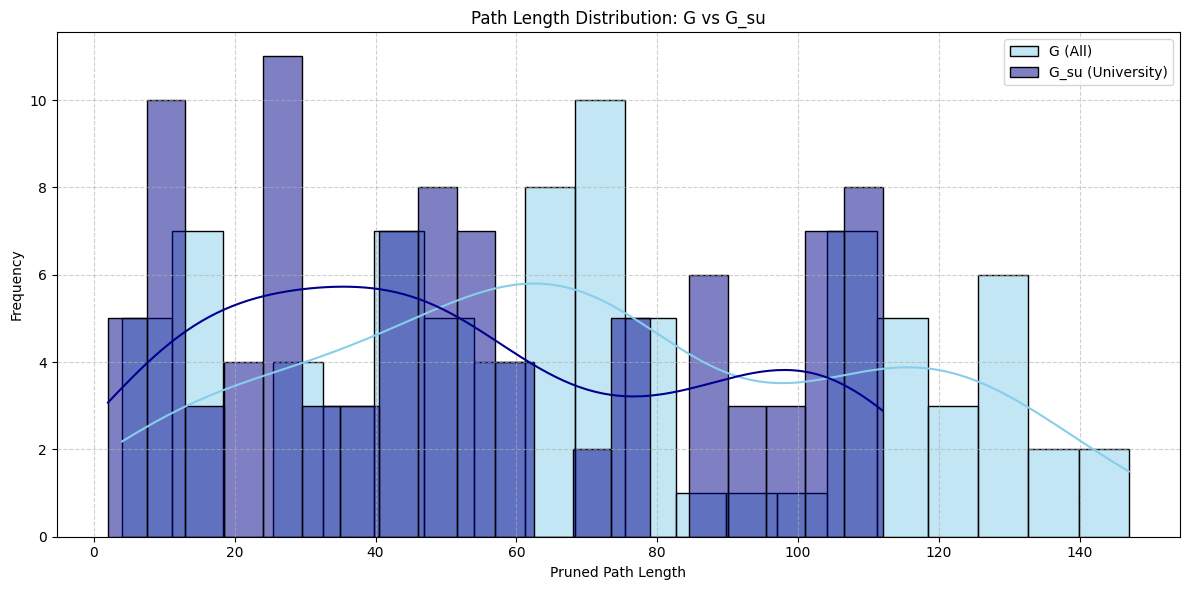


 Top Mid-Path Students in G:
  rohit malviya — 57 times
  nirmal mewada — 53 times
  ravi rajput — 51 times
  neeraj parmar — 50 times
  manoj dewda — 50 times
  byagari praveen kumar — 47 times
  challa trivedh kumar — 46 times
  aman singh — 45 times
  himanshu kumar — 42 times
  janu chaudhary — 40 times

 Top Mid-Path Students in G_su:
  anamika kumari — 51 times
  anoop kumar — 50 times
  mohit sharma — 48 times
  dilip suthar — 48 times
  ramraj nagar — 47 times
  gaurav rathore — 46 times
  n. arun kumar — 46 times
  shivam shukla — 45 times
  debangsu misra — 44 times
  yuvraj chirag — 44 times


In [68]:
unified_graph_analysis_pipeline()